## <span style="color:violet">To see all outputs that Github doesn't show use this link:  </span> 

# Classification. Linear models and KNN

In [373]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [245]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""   
        return 1/(1+np.exp(-X.dot(weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        N = len(y)
        reg = sum(weights**2)/(2*self.C)
        return (sum(np.log(1+ np.exp(-x.dot(weights)*y))))/N + reg
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
        
                                                      high=weight_threshold, size=num_features) # random weight initialization
        for i in range(self.max_iter):
            delta = X_ext.dot(self.weights_)
            delta = -delta*y
            delta = 1+ np.exp(delta)
            delta = 1 - 1/delta
            delta = delta.dot(X_ext*y[:,np.newaxis])
            delta = delta/y.shape[0] 
            delta = self.weights_/self.C - delta
            self.weights_ -=  self.eta*delta
            self.loss_history.append(self.get_loss(X_ext,self.weights_,y))
            if np.linalg.norm(self.eta*delta,2) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X)>0.5,1,-1)

In [5]:
from sklearn import datasets
from sklearn import metrics

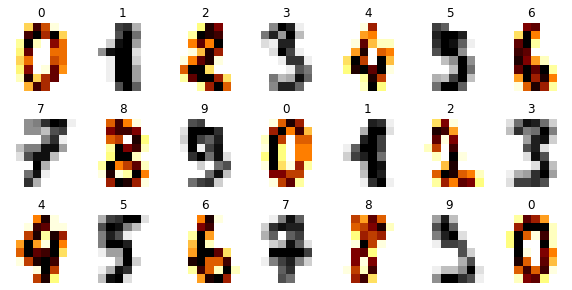

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

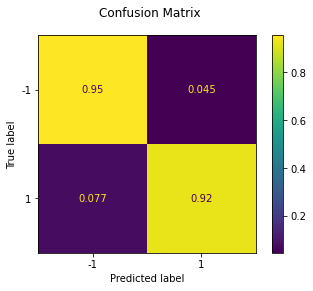

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [17]:
def plot_loss_hist(xlim=0,eta=0.001,max_iter = 1000, C=1.0, show_eta=True):
    model_check = CustomLogisticRegression(eta=eta,max_iter=max_iter,C=C)
    model_check.fit(X_train,y_train)
    if show_eta:
        label = f'eta={eta}'
    else:
        label = f'C={C}'
    plt.plot(model_check.loss_history, label=label)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.title('Log loss history')
    plt.legend()
    if xlim:
        plt.xlim(xlim)
    X_ext = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    print(label)
    print(f'Loss in test: {model_check.get_loss(X_ext,model_check.weights_,y_test)}')

eta=0.001
Loss in test: 0.2797900144761217


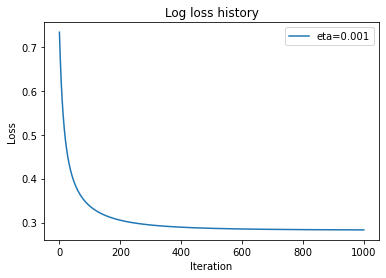

In [18]:
plot_loss_hist()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

eta=0.01
Loss in test: 0.6836904551980835
eta=0.001
Loss in test: 0.2797900144761217


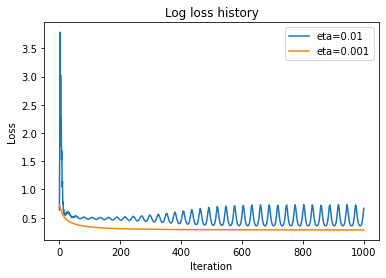

In [19]:
plot_loss_hist(eta=0.01)
plot_loss_hist()

eta=0.1
Loss in test: 21.484052894456283
eta=0.001
Loss in test: 0.2797900144761217


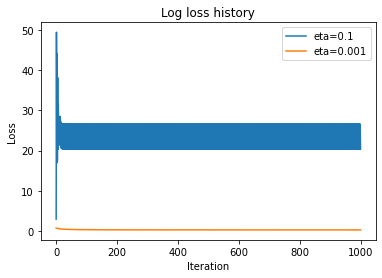

In [20]:
plot_loss_hist(eta=0.1)
plot_loss_hist()

Let's look deeper

eta=0.1
Loss in test: 21.484052894456283
eta=0.001
Loss in test: 0.2797900144761217


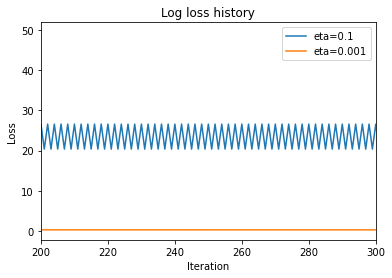

In [21]:
plot_loss_hist(xlim=(200,300),eta=0.1)
plot_loss_hist(xlim=(200,300))

eta=0.0001
Loss in test: 0.2839158969708083
eta=0.001
Loss in test: 0.27946434388200675


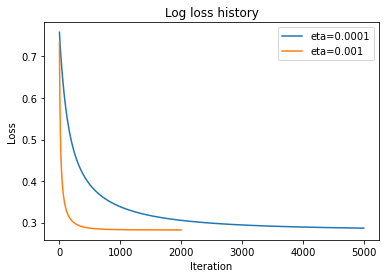

In [22]:
plot_loss_hist(eta=0.0001,max_iter=5000)
plot_loss_hist(max_iter=5000)

By increasing eta(0.01,0.1) plot is changing very fast and with big steps, therefore it can't reach suitable weights with small log loss as by eta = 0.001.
By reducing eta(0.0001) plot is gently sloping, so it needs many times more iterations to reach such good weights as by eta=0.001 reaching it with 1000 iterations (with 2000 iters plot is ending, because it reached changing tolerance).

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C=0.5
Loss in test: 0.32025104513726366
C=1.0
Loss in test: 0.2797900144761217
C=2
Loss in test: 0.24944167809262435
C=10
Loss in test: 0.21477649208647306


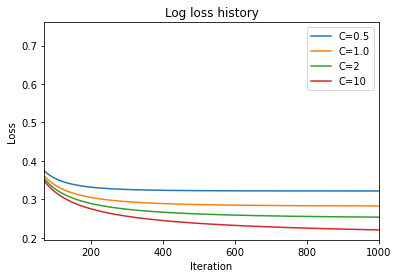

In [23]:
xlim=(70,1000)
plot_loss_hist(xlim=xlim,C=0.5,show_eta=False)
plot_loss_hist(xlim=xlim,show_eta=False)
plot_loss_hist(xlim=xlim,C=2,show_eta=False)
plot_loss_hist(xlim=xlim,C=10,show_eta=False)

Increasing the regularization parameter boosts the model quality.

**(0.5 points)** Compare zero initialization and random initialization. 

Loss in test: 0.2797900144761217
Loss in test: 0.2797732770247276


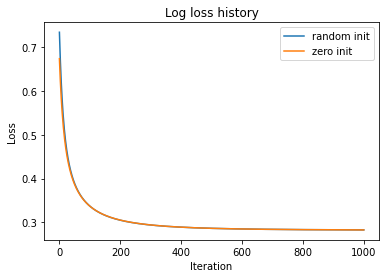

In [24]:
model_check = CustomLogisticRegression()
model_check.fit(X_train,y_train)    
plt.plot(model_check.loss_history, label='random init')
X_ext = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
print(f'Loss in test: {model_check.get_loss(X_ext,model_check.weights_,y_test)}')

model_check = CustomLogisticRegression(zero_init=True)
model_check.fit(X_train,y_train)  
plt.plot(model_check.loss_history, label='zero init')
X_ext = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
print(f'Loss in test: {model_check.get_loss(X_ext,model_check.weights_,y_test)}')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Log loss history')
plt.legend()

It doesn't matter how to init the weights: with zeros or randomly - anyway we get the same result.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [25]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.zeros((len(X), len(Y)))
        for i in range(len(X)):
            for j in range(len(Y)):
                P[i][j]=np.linalg.norm(X[i]-Y[j])
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p=[]
        for cl in self.classes_:
            i = np.where(y==cl)
            p.append(sum(weights[i]))
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            for i in range(P.shape[0]):    #leaving n_neighbors nearest weights,others:=0
                    d_ranged = sorted(P[i])
                    max_d = d_ranged[self.n_neighbors-1]
                    weights_of_points[i][P[i]>max_d] = 0
            if self.weights == 'distance':
                weights_of_points /= (P+self.eps)
                """for i in range(weights_of_points.shape[0]):    #leaving n_neighbors nearest weights,others:=0
                    w_ranged = sorted(weights_of_points[i],reverse=True)
                    min_w = w_ranged[self.n_neighbors-1]
                    weights_of_points[i][weights_of_points[i]<min_w] = 0"""
            
            proba=np.zeros((len(X),len(self.classes_)))
            for i in range(X.shape[0]):
                cl_w = self.get_class_weights(self.y,weights_of_points[i])
                proba[i] = cl_w/sum(cl_w)
            return proba
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = []        
        proba = self.predict_proba(X)
        y = np.argmax(proba,axis=1)
        return y

In [26]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

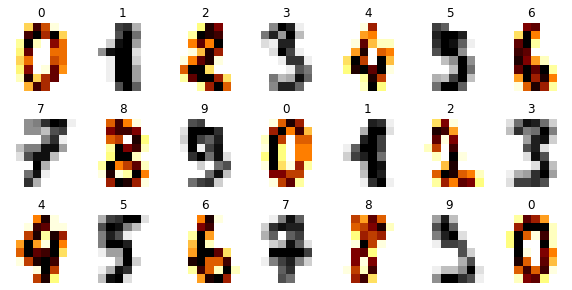

In [29]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [30]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [31]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

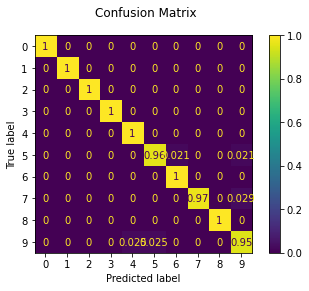

In [32]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model predictes sometimes:
* instead of 5: 6 or 9 
* instead of 7: 9 
* instead of 9: 4 or 5 </br>
It happens because of visual similarity of these numbers images. The images aren't clear enough. For me as human it's also hard to differ some 5s and 9s.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

Text(0, 0.5, 'acccuracy')

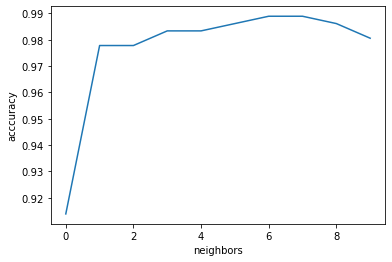

In [34]:
acc_hist = []
for i in range(10):
    model = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    model.fit(X_train,y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    acc_hist.append(test_acc)
    
plt.plot(acc_hist)
plt.xlabel('neighbors')
plt.ylabel('acccuracy')

The best perfomance was reached with neighbors = 6 or 7.

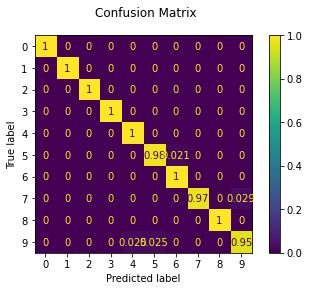

In [35]:
model = CustomKNeighborsClassifier(n_neighbors=6, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

The difference of model with 5 nearest neighbors - the model doesn't predict 9 instead of 5 anymore (now the model is smarter than me:)). I think more neighbors let the model to consider a tail of 5, like: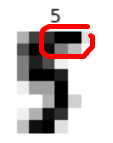

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

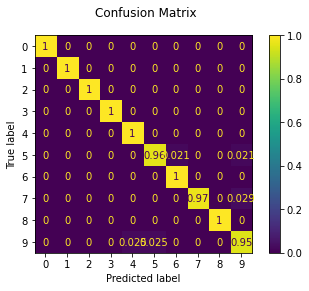

Accuracy:0.9861111111111112


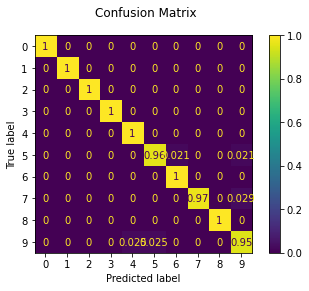

Accuracy:0.9861111111111112


In [36]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Accuracy:{test_acc}')
model = CustomKNeighborsClassifier(n_neighbors=5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Accuracy:{test_acc}')

There is no difference in accuracy btw uniform and distance weights. I think it could differ if the size of picture was larger than 8x8 or the points were more distributed from each other.</br> Because if we take n_neighbors more than 14, the accuracy in uniform model is getting lower.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

We could use the correlations btw points and target class and use in classifer only [n_neighbors] points with highest correlation. It could be more helpfull to detect the exact specific points for a number, than the nearest.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Euclidean distance performs reasonably well over the categorical and numerical datasets, but not for the mixed type of datasets. With mixed type will Chi-square perform better.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [199]:
PATH = "./data/"

In [200]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [201]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [202]:
SURVIVED_COL = 'Survived'
NAME_COL = 'Name'
SEX_COL = 'Sex'
CLASS_COL = 'Pclass'
AGE_COL = 'Age'
SIBSP_COL= 'SibSp'
PARCH_COL = 'Parch'
TICKET_COL ='Ticket'
PRICE_COL = 'Fare'
CABIN_COL = 'Cabin'
PORT_COL = 'Embarked'
ID_COL = 'PassengerId'
RELATIV_COL = 'Relatives'

DATA_LEN = len(data)

In [203]:
def bar_survive(feature,colors):
    survived = data[data[SURVIVED_COL]==1][feature].value_counts()
    dead = data[data[SURVIVED_COL]==0][feature].value_counts()
    if ("NO INFO" in survived.index):
        survived = survived.drop(index='NO INFO')
    if ("NO INFO" in dead.index):
        dead = dead.drop(index='NO INFO')
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind ='bar',stacked='True',color=colors)

In [204]:
data[SEX_COL].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

<AxesSubplot:ylabel='Sex'>

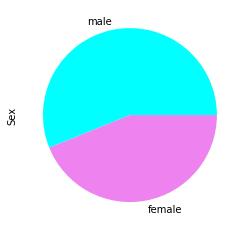

In [205]:
data[SEX_COL].value_counts().plot.pie(colors=['aqua','violet'])

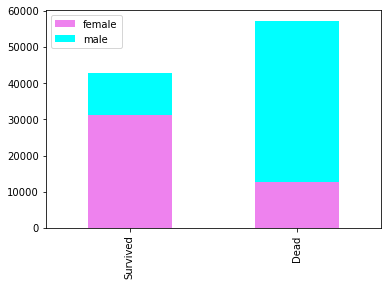

In [206]:
bar_survive(SEX_COL,['violet','aqua'])

The survival rate of women is around 4 times higher than of men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0.5, 1.0, 'Age')

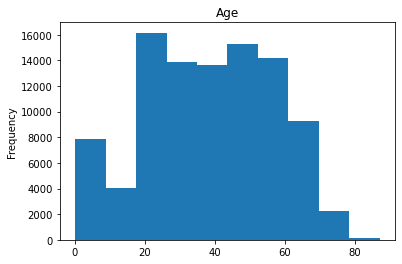

In [207]:
data[AGE_COL].plot(kind='hist', xlabel='Age').set_title('Age')

In [208]:
print('Deceased:')
data[data.Survived==0][AGE_COL].describe()

Deceased:


count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

In [209]:
print('Survived:')
data[data.Survived==1][AGE_COL].describe()

Survived:


count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

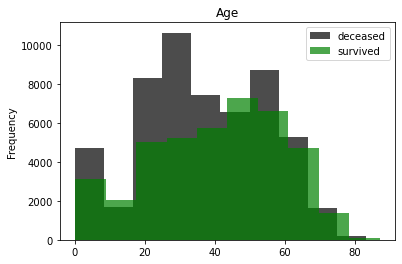

In [210]:
data[data.Survived==0][AGE_COL].plot(kind='hist', xlabel='Age',label='deceased',
                                     alpha=0.7,color='black').set_title('Age')
data[data.Survived==1][AGE_COL].plot(kind='hist', xlabel='Age',label='survived',
                                     alpha=0.7,color='green').set_title('Age')
plt.legend()

Passengers with age on [0,17]&[37,90] have more chanses to survive: amount of survived is more than 1/2 of deceased.</br>
Childrens survived because children and women are saving first of all. The people older than 37 are more wealthy therefore have more privilege to be saved.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

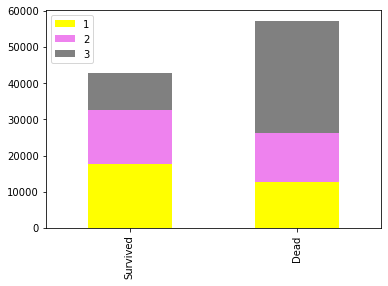

In [211]:
bar_survive(CLASS_COL,['yellow','violet','grey'])

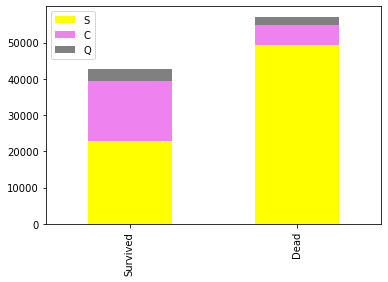

In [212]:
bar_survive(PORT_COL,['yellow','violet','grey'])

First and second class are much safer (1st the safest) than third class. Few people from 3rd class survived comparing to deceased. </br>
Most of C embarked survived(odds 3:1). People who embarked in S had odds to survive 1:2.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [225]:
def col_nans(data):
    print('Columns with Nans:')
    column_names = data.columns
    for c in range(len(column_names)):
        if data[column_names[c]].hasnans:
            print (column_names[c])
            print (str(len(data[data[column_names[c]].isna()]) / DATA_LEN *100) + '% of Nans')

col_nans(data)

Columns with Nans:
Ticket
4.623% of Nans


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

* For Age I would find the most correlated features and fill Nans with mean age of according records with same features values.
* In Embarked and Fare columns is missing amount very small, so I would just fill it with most popular port(S) and with mean of class fare.
* The fact of Cabin value missing is also meaningfull, so i would fill it with tag 'No info'.
* Ticket columns I would not change and leave Nans, because I'm not sure about importance of this column in predictions at the moment. 

Disadvantages of filling with means is that it can increase the amount of incorrect data and show the model wrong dependencies. The missing amount is small in these cases, so i think it could bring more profit and model stability, than harm.</br>
Also if we fill a lot of records with means or other function of other features, we will get a linear dependence btw features and filled feature will be useless. That's why I'm leaving Cabin info as it is.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [236]:
#change Cabin name to first letter
data.at[data[CABIN_COL].notna(),CABIN_COL] = data[data[CABIN_COL].notna()][CABIN_COL].apply(lambda x : x[0:1])
data[CABIN_COL] = data[CABIN_COL].fillna('NO INFO')
sorted(data[CABIN_COL].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'T']

In [237]:
data[PORT_COL] = data[PORT_COL].fillna('S') #filling Nans with S Port

In [282]:
def fact_col(data,col):
    data[col] = data[col].factorize()[0]
    print(f'Unique {col}:{data[col].unique()}')

In [283]:
""""Creating a dataset with categorial vars changed to numeric"""
num_data = data.copy() 
fact_col(num_data,PORT_COL) #0-S,1-C,2-Q
fact_col(num_data,SEX_COL) #0-male,1-female
num_data = num_data.sort_values(by=CABIN_COL)
fact_col(num_data,CABIN_COL) #alphabetic
num_data = num_data.sort_values(by=ID_COL)

Unique Embarked:[0 1 2]
Unique Sex:[0 1]
Unique Cabin:[0 1 2 3 4 5 6 7 8]


<AxesSubplot:>

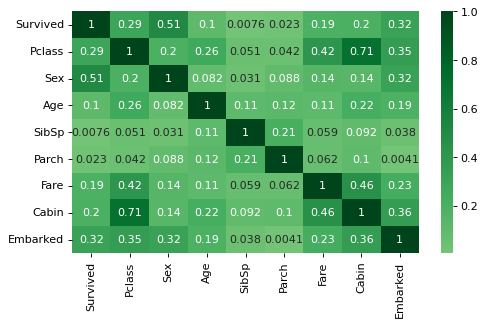

In [284]:
plt.figure(figsize=(7, 4), dpi=80)
sns.heatmap(abs(num_data.corr()),center=0,annot=True,cmap='Greens')

Now we can see much more dependencies on correlation matrix.
* Cabins and Class corr = 0.71
* Survivial depends on :
 * Sex with 0.51 
 * Port with 0.32 
 * Class with 0.29
 * Fare with 0.19
 * and on Age only with 0.1
* Age corrs with Class the most (0.26)

In [285]:
""""Filling Nans in Fare and Age with mean of Class  """
for cl in range(1,4):   
    mask = data[CLASS_COL]==(cl)
    mean_price = data[mask][PRICE_COL].mean()
    mean_age = data[mask][AGE_COL].mean()
    data.loc[mask,PRICE_COL] = data.loc[mask,PRICE_COL].fillna(mean_price)  
    data.loc[mask,AGE_COL] = data.loc[mask,AGE_COL].fillna(mean_age)

num_data[AGE_COL] = data[AGE_COL]
num_data[PRICE_COL] = data[PRICE_COL]

In [286]:
"""Combining SibSp and ParCh columns to Relatives column"""
num_data['Relatives'] = num_data[PARCH_COL]+num_data[SIBSP_COL]
num_data = num_data.drop([SIBSP_COL,PARCH_COL],axis=1)

<AxesSubplot:>

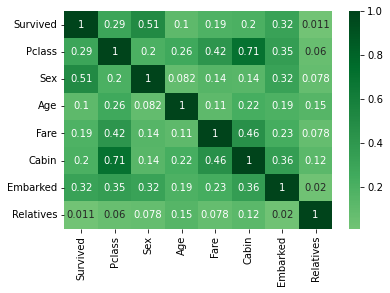

In [287]:
sns.heatmap(abs(num_data.corr()),center=0,annot=True,cmap='Greens')

Now the Relatives feature shows a little bigger corr coefficient.

In [327]:
num_data = num_data.drop([TICKET_COL,NAME_COL],axis=1)
col_nans(num_data)

Columns with Nans:


Now the features are ready for modelling.

In [410]:
y = num_data[SURVIVED_COL]
X = num_data.drop(SURVIVED_COL,axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Pclass     100000 non-null  int64  
 1   Sex        100000 non-null  int64  
 2   Age        100000 non-null  float64
 3   Fare       100000 non-null  float64
 4   Cabin      100000 non-null  int64  
 5   Embarked   100000 non-null  int64  
 6   Relatives  100000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 6.1 MB


In [344]:
def cross_check(model,X,y,prt=True):
    results = cross_validate(t_model, 
                                 X, y, cv=5,
                                 return_train_score=True,
                                 scoring='accuracy')
    tr_s,te_s = results['train_score'].mean(),results['test_score'].mean()
    if prt:
        print(f'Train accuracy: {tr_s}')
        print(f'Test accuracy: {te_s}')
    else:
        return te_s

In [407]:
X

,Pclass,Sex,Age,Fare,Cabin,Embarked,Relatives
PassengerId,,,,,,,
0,1,0,44.774464,27.14,2,0,2
1,3,0,33.407362,13.35,7,0,0
2,3,0,0.330000,71.29,7,0,3
3,3,0,19.000000,13.04,7,0,0
4,3,0,25.000000,7.76,7,0,0
...,...,...,...,...,...,...,...
99995,2,1,62.000000,14.86,3,1,0
99996,2,0,66.000000,11.15,7,0,0
99997,3,0,37.000000,9.95,7,0,0


In [424]:
X = StandardScaler().fit_transform(X)

In [419]:
t_model = LogisticRegression(max_iter=1000)
cross_check(t_model,X,y)

Train accuracy: 0.758435
Test accuracy: 0.7585200000000001


In [413]:
t_model = KNeighborsClassifier(n_neighbors=20, weights='distance')
cross_check(t_model,X,y)

Train accuracy: 0.99445
Test accuracy: 0.7493000000000001


Model is overfitted.

In [340]:
t_model = KNeighborsClassifier(n_neighbors=20, weights='uniform')
cross_check(t_model,X,y)

Train accuracy: 0.755545
Test accuracy: 0.72811


Text(0, 0.5, 'accuracy')

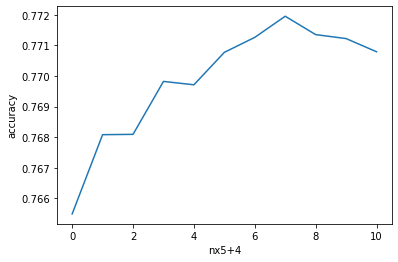

In [444]:
acc_hist=[]
for n in range(4,15):
    t_model = KNeighborsClassifier(n_neighbors=n*5, weights='uniform')
    acc_hist.append(cross_check(t_model,X,y,prt=False))
plt.plot(acc_hist)
plt.xlabel('n\5-4')
plt.ylabel('accuracy')

Best perfomance is btw [50,60] neighbors.

In [ ]:
acc_hist=[]
for n in range(50,60):
    t_model = KNeighborsClassifier(n_neighbors=n, weights='uniform')
    acc_hist.append(cross_check(t_model,X,y,prt=False))
plt.plot(acc_hist)   
plt.xlabel('n-50')
plt.ylabel('accuracy')

In [415]:
t_model = KNeighborsClassifier(n_neighbors=13, weights='uniform')
cross_check(t_model,X,y)

Train accuracy: 0.79196
Test accuracy: 0.76522


In [440]:
X = num_data[[SEX_COL,PORT_COL,PRICE_COL,CABIN_COL]]
X = StandardScaler().fit_transform(X)

In [442]:
t_model = KNeighborsClassifier(n_neighbors=13, weights='uniform')
cross_check(t_model,X,y)

Train accuracy: 0.78861
Test accuracy: 0.7624500000000001


In [420]:
t_model = KNeighborsClassifier(n_neighbors=13, weights='uniform')
t_model.fit(X,y)

KNeighborsClassifier(n_neighbors=13)

In [ ]:
###new feature 
m_3 = num_data[(num_data[SEX_COL]==0)&(num_data[CLASS_COL]==3)]
#num_data['Man_3_Class'] = 
m_3

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [350]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [351]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


Turning test data to form like by train data:

In [352]:
col_nans(test_data)

Columns with Nans:
Age
3.4869999999999997% of Nans
Ticket
5.181% of Nans
Fare
0.133% of Nans
Cabin
70.831% of Nans
Embarked
0.27699999999999997% of Nans


In [ ]:
test_data['Relatives'] = test_data[PARCH_COL]+test_data[SIBSP_COL]
test_data = test_data.drop([SIBSP_COL,PARCH_COL,TICKET_COL,NAME_COL],axis=1)

In [356]:
test_data.at[test_data[CABIN_COL].notna(),CABIN_COL] = test_data[test_data[CABIN_COL].notna()][CABIN_COL].apply(lambda x : x[0:1])
test_data[CABIN_COL] = test_data[CABIN_COL].fillna('NO INFO')
sorted(data[CABIN_COL].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'N', 'T']

In [ ]:
for cl in range(1,4):   
    mask = test_data[CLASS_COL]==(cl)
    test_data.loc[mask,PRICE_COL] = test_data.loc[mask,PRICE_COL].fillna(mean_price)  
    test_data.loc[mask,AGE_COL] = test_data.loc[mask,AGE_COL].fillna(mean_age)

test_data[AGE_COL] = test_data[AGE_COL]
test_data[PRICE_COL] = test_data[PRICE_COL]

In [359]:
test_data[PORT_COL] = test_data[PORT_COL].fillna('S')

In [360]:
col_nans(test_data)

Columns with Nans:


In [361]:
fact_col(test_data,PORT_COL)
fact_col(test_data,SEX_COL)

test_data = test_data.sort_values(by=CABIN_COL)
fact_col(test_data,CABIN_COL)
test_data = test_data.sort_values(by=ID_COL)

Unique Embarked:[0 1 2]
Unique Sex:[0 1]
Unique Cabin:[0 1 2 3 4 5 6 7 8]


In [362]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100000 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Pclass     100000 non-null  int64  
 1   Sex        100000 non-null  int64  
 2   Age        100000 non-null  float64
 3   Fare       100000 non-null  float64
 4   Cabin      100000 non-null  int64  
 5   Embarked   100000 non-null  int64  
 6   Relatives  100000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 6.1 MB


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [421]:
X = StandardScaler().fit_transform(test_data)
y_test = t_model.predict(X)
survive_data = pd.Series(y_test,index=test_data.index,name='Survived')

In [422]:
survive_data.to_csv('Survive.csv')

### SCORE = 0.775